In [1]:
import pylab as plt
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks", context="poster")

import astropy
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as ac
import astropy.units as u
import gala.coordinates as gc
import galstreams

from astroML.density_estimation import XDGMM
from sklearn.mixture import GaussianMixture

from scipy.optimize import curve_fit

from scipy.stats import multivariate_normal
from scipy.stats import norm

import os #Avoids issues with paralellization in emcee
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool
import time
import emcee
import corner

In [2]:
#Cargo tabla de datos
f = fits.open('RRLwithprobthin.fit')  # open a FITS file
data = f[1].data  # assume the first extension is a table
header = f[1].header
# print(Table(data))
# print(header)
# data.columns

In [3]:
#Transformo coordenadas y obtengo track
_ = ac.galactocentric_frame_defaults.set('v4.0') #set the default Astropy Galactocentric frame parameters to the values adopted in Astropy v4.0

c = ac.ICRS(ra=data['RA_ICRS']*u.degree, dec=data['DE_ICRS']*u.degree, pm_ra_cosdec=data['pmRA']*u.mas/u.yr, pm_dec=data['pmDE']*u.mas/u.yr)
pal = c.transform_to(gc.Pal5PriceWhelan18())

phi1 = pal.phi1 #deg
phi2 = pal.phi2 #deg
pmphi1 = pal.pm_phi1_cosphi2 #mas/yr
pmphi2 = pal.pm_phi2 #mas/yr
d = data['Dist'] #kpc


st = "Pal5-PW19"
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)
track = mwsts[st].track
pal_track = track.transform_to(gc.Pal5PriceWhelan18())

phi1_t = pal_track.phi1
phi2_t = pal_track.phi2
pmphi1_t = pal_track.pm_phi1_cosphi2
pmphi2_t = pal_track.pm_phi2 

Initializing galstreams library from master_log... 


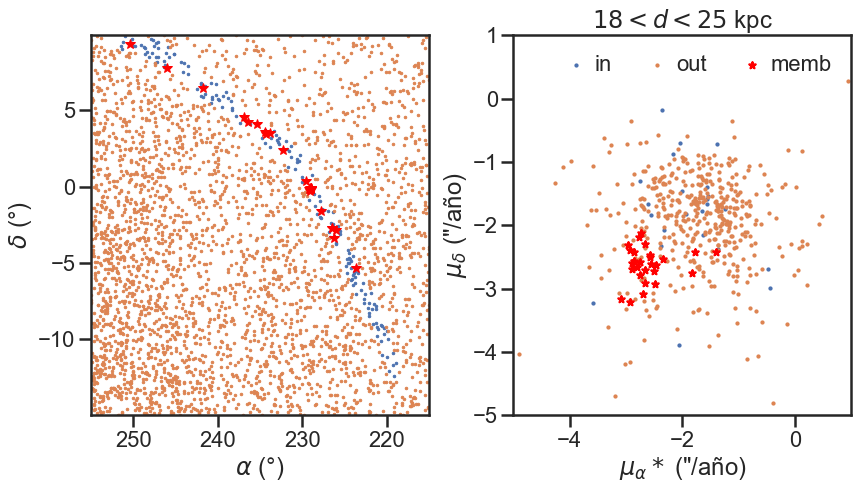

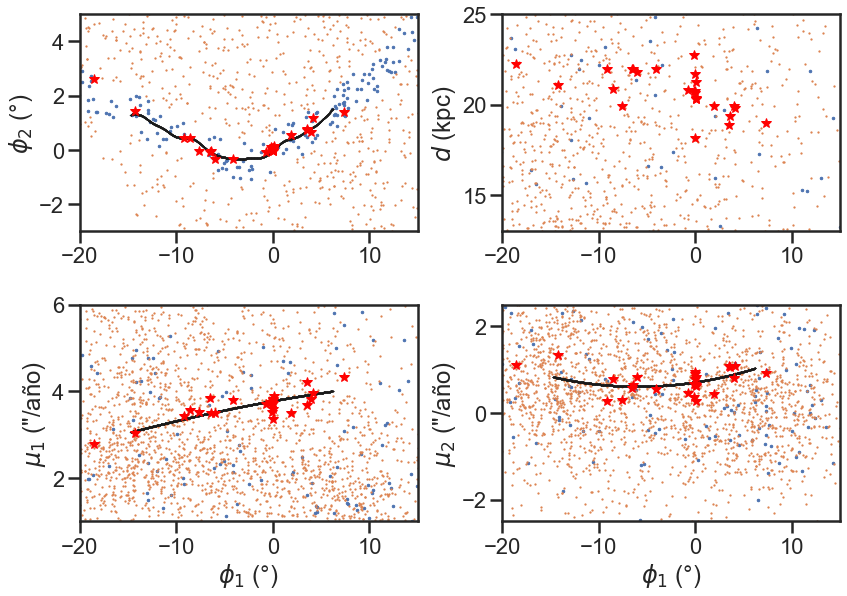

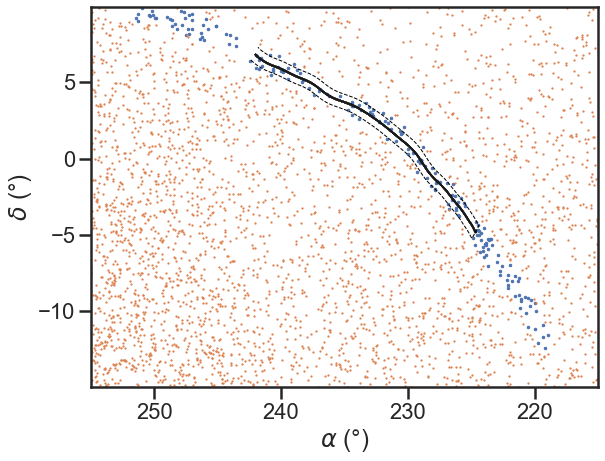

In [4]:
#Estrellas del track y del fondo

d_in = (data['Dist']>18) & (data['Dist']<25)
inside = (data['Track']==1) 
out = (data['Track']==0)
miembro = inside & (data['Memb']>0.5)

fig=plt.figure(1,figsize=(12,6))
fig.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
ax=fig.add_subplot(121)
ax.plot(data[inside]['RA_ICRS'],data[inside]['DE_ICRS'],'.',ms=5)
ax.plot(data[out]['RA_ICRS'],data[out]['DE_ICRS'],'.',ms=5)
ax.plot(data[miembro]['RA_ICRS'],data[miembro]['DE_ICRS'],'*',c='red',ms=10)
ax.set_xlabel('$\\alpha$ (°)')
ax.set_ylabel('$\delta$ (°)')
ax.set_xlim([max(data['RA_ICRS']), min(data['RA_ICRS'])])
ax.set_ylim([min(data['DE_ICRS']), max(data['DE_ICRS'])])

ax=fig.add_subplot(122)
ax.scatter(data[inside & d_in]['pmRA'],data[inside & d_in]['pmDE'],s=5, label='in')
ax.scatter(data[out & d_in]['pmRA'],data[out & d_in]['pmDE'],s=5, label='out')
ax.scatter(data[miembro & d_in]['pmRA'],data[miembro & d_in]['pmDE'],s=50, marker='*',color='red', label='memb')
ax.set_xlabel('$\mu_\\alpha*$ ("/año)')
ax.set_ylabel('$\mu_\delta$ ("/año)')
ax.set_title('$18 < d < 25$ kpc')
ax.legend(frameon=False, ncol=3, handlelength=0.1)
ax.set_xlim([-5,1])
ax.set_ylim([-5,1]);


fig2=plt.figure(2,figsize=(12,8))
fig2.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
ax2=fig2.add_subplot(221)
ax2.plot(phi1[inside],phi2[inside],'.',ms=5)
ax2.plot(phi1[out],phi2[out],'.',ms=2.5)
ax2.plot(phi1_t,phi2_t,'k.',ms=1.)
ax2.plot(phi1[miembro],phi2[miembro],'*',c='red',ms=10.)
# ax2.set_xlabel('$\phi_1$ (°)')
ax2.set_ylabel('$\phi_2$ (°)')
ax2.set_xlim([-20,15])
ax2.set_ylim([-3,5])

ax2=fig2.add_subplot(222)
ax2.plot(phi1[inside],d[inside],'.',ms=5)
ax2.plot(phi1[out],d[out],'.',ms=2.5)
ax2.plot(phi1[miembro],d[miembro],'*',c='red',ms=10.)
# ax2.set_xlabel('$\phi_1$ (°)')
ax2.set_ylabel('$d$ (kpc)')
ax2.set_xlim([-20,15])
ax2.set_ylim([13,25])

ax2=fig2.add_subplot(223)
ax2.plot(phi1[inside],pmphi1[inside],'.',ms=5)
ax2.plot(phi1[out],pmphi1[out],'.',ms=2.5)
ax2.plot(phi1_t,pmphi1_t,'k.',ms=1.)
ax2.plot(phi1[miembro],pmphi1[miembro],'*',c='red',ms=10.)
ax2.set_xlabel('$\phi_1$ (°)')
ax2.set_ylabel('$\mu_1$ ("/año)')
ax2.set_xlim([-20,15])
ax2.set_ylim([1,6])

ax2=fig2.add_subplot(224)
ax2.plot(phi1[inside],pmphi2[inside],'.',ms=5)
ax2.plot(phi1[out],pmphi2[out],'.',ms=2.5)
ax2.plot(phi1_t,pmphi2_t,'k.',ms=1.)
ax2.plot(phi1[miembro],pmphi2[miembro],'*',c='red',ms=10.)
ax2.set_xlabel('$\phi_1$ (°)')
ax2.set_ylabel('$\mu_2$ ("/año)')
ax2.set_xlim([-20,15])
ax2.set_ylim([-2.5,2.5]);


# st = "Pal5-PW19"
fig3=plt.figure(3,figsize=(8,6))
fig3.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
ax3=fig3.add_subplot(111)
ax3.plot(data[inside]['RA_ICRS'],data[inside]['DE_ICRS'],'.',ms=5)
ax3.plot(data[out]['RA_ICRS'],data[out]['DE_ICRS'],'.',ms=2.5)
ax3.plot(track.ra, track.dec, 'k.', ms=1.)
ax3.plot(mwsts[st].poly_sc.icrs.ra, mwsts[st].poly_sc.icrs.dec, lw=1.,ls='--', color='black')
ax3.set_xlabel('$\\alpha$ (°)')
ax3.set_ylabel('$\delta$ (°)')
ax3.set_xlim([max(data['RA_ICRS']), min(data['RA_ICRS'])])
ax3.set_ylim([min(data['DE_ICRS']), max(data['DE_ICRS'])]);

In [5]:
##Modelo del fondo

st = "Pal5-PW19"
ra = data['RA_ICRS']
e_ra = data['e_RA_ICRS']/3600
dec = data['DE_ICRS']
e_dec = data['e_DE_ICRS']/3600

pmra = data['pmRA']
e_pmra = data['e_pmRA']
pmdec = data['pmDE']
e_pmdec = data['e_pmDE']

field = ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
#Select the field points inside the polygon footprint
off = ~mwsts[st].get_mask_in_poly_footprint(field)

ra_out = ra[off]
dec_out = dec[off]
e_ra_out = e_ra[off]
e_dec_out = e_dec[off]

pmra_out = pmra[off]
pmdec_out = pmdec[off]
e_pmra_out = e_pmra[off]
e_pmdec_out = e_pmdec[off]

d_out = d[off]
e_d_out = d_out*0.03

# fig=plt.figure(1,figsize=(8,6))
# fig.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
# ax=fig.add_subplot(111)
# ax.scatter(ra_out+50, dec_out+50, s=5)
# ax.scatter(ra_out, dec_out, s=2.5)
# ax.set_xlim([max(ra_out), min(ra_out)])
# ax.set_ylim([min(dec_out), max(dec_out)])
# ax.set_xlabel('$\\alpha$ (°)')
# ax.set_ylabel('$\delta$ (°)')
# ax.set_title('Backgroud');

In [6]:
##Extreme deconvolution en pm y d

X = np.vstack([pmra_out, pmdec_out, d_out]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([e_pmra_out**2, e_pmdec_out**2, e_d_out**2]).T

#Busco mejor numero de gaussianas
def compute_XDGMM(N, max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        print("N =", N[i])
        models[i] = XDGMM(n_components=N[i], max_iter=max_iter)
        models[i].fit(X, Xerr)
    return models

def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter, covariance_type=covariance_type)
        models[i].fit(X)
        print("best fit converged:", models[i].converged_)
    return models

# N = np.arange(3,13) #Con 1 gaussiana da error
N = np.arange(6,7) #Fuerzo a que sean 6 gaussianas
models = compute_XDGMM(N)
models_gmm = compute_GaussianMixture(N)


N = 6
C:\Users\win8.1\anaconda3\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(

best fit converged: True


In [7]:
#Busco minimo BIC
BIC = [None for n in N]
BIC_gmm2 = [None for n in N]
for i in range(len(N)):
    k = (N[i]-1) + np.tri(X.shape[1]).sum()*N[i] + X.shape[1]*N[i] #N_componentes = Pesos + covariaza(matiz simetrica) + medias
    BIC[i] = -2*models[i].logL(X,Xerr) + k*np.log(X.shape[0])
    BIC_gmm2[i] = -2*np.sum(models_gmm[i].score_samples(X)) + k*np.log(X.shape[0])
BIC_gmm = [m.bic(X) for m in models_gmm]

i_best = np.argmin(BIC)
i_best_gmm = np.argmin(BIC_gmm)

xdgmm_best = models[i_best]
gmm_best = models_gmm[i_best] #Me quedo con el mejor modelo de gmm segun xd

BIC: n_components =  7
BIC_gmm: n_components =  9


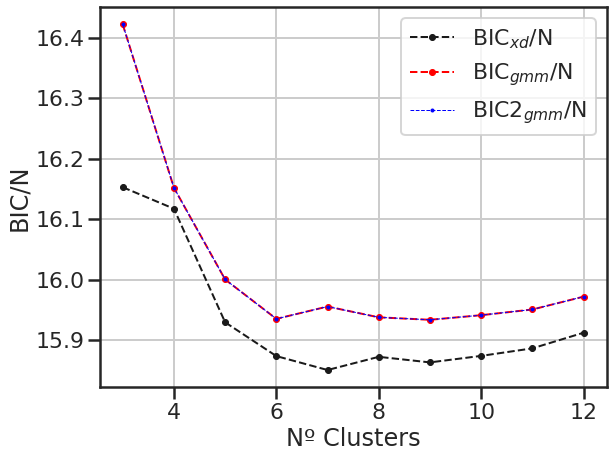

In [5]:
#Busco minimo BIC
BIC = [None for n in N]
BIC_gmm2 = [None for n in N]
for i in range(len(N)):
    k = (N[i]-1) + np.tri(X.shape[1]).sum()*N[i] + X.shape[1]*N[i] #N_componentes = Pesos + covariaza(matiz simetrica) + medias
    BIC[i] = -2*models[i].logL(X,Xerr) + k*np.log(X.shape[0])
    BIC_gmm2[i] = -2*np.sum(models_gmm[i].score_samples(X)) + k*np.log(X.shape[0])
BIC_gmm = [m.bic(X) for m in models_gmm]

i_best = np.argmin(BIC)
i_best_gmm = np.argmin(BIC_gmm)

xdgmm_best = models[i_best]
gmm_best = models_gmm[i_best] #Me quedo con el mejor modelo de gmm segun xd

# fig=plt.figure(1,figsize=(8,6))
# fig.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
# ax=fig.add_subplot(111)
# ax.plot(N, np.array(BIC)/X.shape[0], '--k', marker='o', lw=2, ms=6, label='BIC$_{xd}$/N')
# ax.plot(N, np.array(BIC_gmm)/X.shape[0], '--', c='red', marker='o', lw=2, ms=6, label='BIC$_{gmm}$/N')
# ax.plot(N, np.array(BIC_gmm2)/X.shape[0], '--', c='blue', marker='o', lw=1., ms=3, label='BIC2$_{gmm}$/N')
# # ax.plot(N, np.array(BIC3)/X.size, '--b', marker='o', lw=2, ms=6, label='BIC3/N')
# ax.legend()
# ax.set_xlabel('Nº Clusters')
# ax.set_ylabel('BIC/N')
# ax.grid()
# fig.savefig('BICs.png')

# print("BIC: n_components =  %i" % N[i_best])
# print("BIC_gmm: n_components =  %i" % N[i_best_gmm])

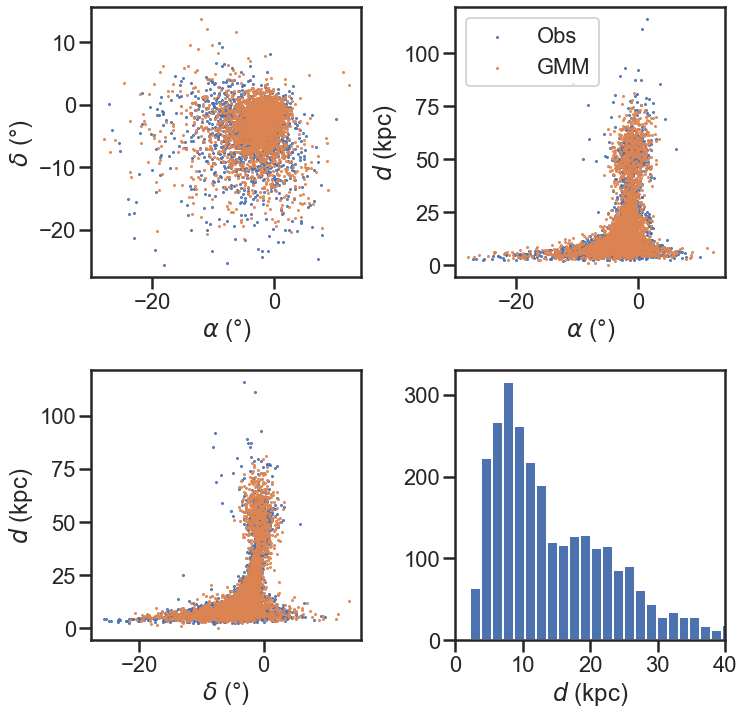

In [31]:
#Comparo modelo del fondo con los datos
sample = gmm_best.sample(ra_out.size)

fig=plt.figure(1,figsize=(10,10))
fig.subplots_adjust(wspace=0.35,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
ax=fig.add_subplot(221)
ax.scatter(pmra_out, pmdec_out, s=1, label='Obs')
ax.scatter(sample[0][:,0], sample[0][:,1], s=1, label='GMM')
# ax.legend()
ax.set_xlabel('$\\alpha$ (°)')
ax.set_ylabel('$\delta$ (°)')
# ax.set_xlim([-5,1])
# ax.set_ylim([-5,1])

ax=fig.add_subplot(222)
ax.scatter(pmra_out, d_out, s=1, label='Obs')
ax.scatter(sample[0][:,0], sample[0][:,2], s=1, label='GMM')
ax.legend()
ax.set_xlabel('$\\alpha$ (°)')
ax.set_ylabel('$d$ (kpc)')
# ax.set_xlim([-5,1])
# ax.set_ylim([-5,1])

ax=fig.add_subplot(223)
ax.scatter(pmdec_out, d_out, s=1, label='Obs')
ax.scatter(sample[0][:,1], sample[0][:,2], s=1, label='GMM')
ax.set_xlabel('$\delta$ (°)')
ax.set_ylabel('$d$ (kpc)')
# ax.set_xlim([-5,1])
# ax.set_ylim([-5,1])

ax=fig.add_subplot(224)
ax.hist(d_out,bins=70)
ax.set_xlim(0,40.)
ax.set_xlabel('$d$ (kpc)');

In [8]:
#Defino vector de valores y matriz de covarianza del stream
y = np.array([pmphi1.value, pmphi2.value, d])
C = np.array([[0.05**2, 0., 0.], [0., 0.05**2, 0.], [0., 0., 0.2**2]]) #mas/yr, mas/yr, kpc

In [14]:
#Defino log-likelihood del stream

theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081])

def log_st(theta_st, phi1, y, C):
    a_mu1, a_mu2, a_d, b_mu1, b_mu2, b_d, c_mu1, c_mu2, c_d, x_mu1, x_mu2, x_d = theta_st
    
    model_mu1 = a_mu1 + b_mu1*(phi1.value-x_mu1) + c_mu1*(phi1.value-x_mu1)**2
    model_mu2 = a_mu2 + b_mu2*(phi1.value-x_mu2) + c_mu2*(phi1.value-x_mu2)**2
    model_d = a_d + b_d*(phi1.value-x_d) + c_d*(phi1.value-x_d)**2
    model = np.array([model_mu1, model_mu2, model_d])
    
    return np.diagonal(-0.5 *(np.matmul( np.matmul((y - model).T , np.linalg.inv(C) ) , (y - model) ) + np.log((2*np.pi)**y.shape[0] * np.linalg.det(C))))

#Defino probabilidad del fondo para cada estrella n
# p_bgn = np.sum(np.exp(xdgmm_best.logprob_a(X, Xerr)), axis=1) #logprob_a devuelve la prob en cada gaussiana
p_bgn = np.exp(gmm_best.score_samples(np.vstack([pmra, pmdec, d]).T)) #Uso el mejor modelo de gmm segun xd
# np.save('p_bgn.npy', p_bgn)
# p_bgn = np.load('p_bgn.npy')


#Defino log-likelihood 
def log_likelihood(theta, phi1, y, C, p_bgn):
    theta_st = theta[0:12]
    f = theta[12]
    return np.sum(np.log( f * np.exp(log_st(theta_st, phi1, y, C)) + (1-f) * p_bgn))


In [10]:
#Defino prior

mu = np.array([-2.728, -2.687])
d_mean = 23.6
e_mu1, e_mu2, rho_mu, e_dd = 0.022, 0.025, -0.39, 0.8
cov_mu = rho_mu*e_mu1*e_mu2 #rho_xy = sigma_xy/(sigma_x*sigma_y)
sigma = np.array([[(e_mu1*10)**2, -(cov_mu*10)**2], [-(cov_mu*10)**2, (e_mu2*10)**2]])
print('VAPs: ',np.linalg.eig(sigma)[0])



def log_unif(p, lim_inf, lim_sup):
    if p>lim_inf and p<lim_sup:
        return 0.0
    return -np.inf


def log_prior(theta):
    a_mu1, a_mu2, a_d, b_mu1, b_mu2, b_d, c_mu1, c_mu2, c_d, x_mu1, x_mu2, x_d, f = theta
    
    p_a12 = multivariate_normal.logpdf(np.stack((a_mu1, a_mu2), axis=-1), mean=mu, cov=sigma)
    p_ad = norm.logpdf(a_d, loc=d_mean, scale=e_dd*5)
    
    p_b1 = log_unif(b_mu1, -100, 100)
    p_b2 = log_unif(b_mu2, -100, 100)
    p_bd = log_unif(b_d, -100, 100)
    
    p_c1 = log_unif(c_mu1, -100, 100)
    p_c2 = log_unif(c_mu2, -100, 100)
    p_cd = log_unif(c_d, -100, 100)
    
    p_x1 = log_unif(x_mu1, -20, 15)
    p_x2 = log_unif(x_mu2, -20, 15)
    p_xd = log_unif(x_d, -20, 15)
                    
    p_f = log_unif(f, 0, 1)
                    
    return p_a12 + p_ad + p_b1 + p_b2 + p_bd + p_c1 + p_c2 + p_cd + p_x1 + p_x2 + p_xd + p_f


def prior_sample(mu, sigma, d_mean, e_dd, n):
    a_mu1, a_mu2 = np.random.multivariate_normal(mu, sigma, n).T
    a_d = np.random.normal(d_mean, e_dd, n)
    
    b_mu1 = np.random.uniform(-100, 100, n).T
    b_mu2 = np.random.uniform(-100, 100, n).T
    b_d = np.random.uniform(-100, 100, n).T
    
    c_mu1 = np.random.uniform(-100, 100, n).T
    c_mu2 = np.random.uniform(-100, 100, n).T
    c_d = np.random.uniform(-100, 100, n).T
    
    x_mu1 = np.random.uniform(-20, 15, n).T
    x_mu2 = np.random.uniform(-20, 15, n).T
    x_d = np.random.uniform(-20, 15, n).T

    f = np.random.uniform(0, 1, n).T

    return np.stack((a_mu1, a_mu2, a_d, b_mu1, b_mu2, b_d, c_mu1, c_mu2, c_d, x_mu1, x_mu2, x_d, f), axis=-1)

VAPs:  [0.0484 0.0625]


In [11]:
#Defino posterior
def log_posterior(theta, phi1, y, C, p_bgn):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, phi1, y, C, p_bgn)

In [12]:
#Valores iniciales

theta_true = np.array([3.740, 0.686, 22.022, 4.102e-2, -2.826e-2, 9.460e-3, -6.423e-4, 2.832e-3, -6.327e-3, -1.072, -10.954, -16.081])

# miembro = (data['Memb']>0.7)

def model(phi1, a, b, c, x):
    return a + b*(phi1-x) + c*(phi1-x)**2

params_mu1, _ = curve_fit(model, phi1.value[miembro], pmphi1.value[miembro])
params_mu2, _ = curve_fit(model, phi1.value[miembro], pmphi2.value[miembro])
params_d, _ = curve_fit(model, phi1.value[miembro], d[miembro])

init = np.array([params_mu1[0], params_mu2[0], params_d[0], params_mu1[1], params_mu2[1], params_d[1], params_mu1[2], params_mu2[2], params_d[2], params_mu1[3], params_mu2[3], params_d[3], np.random.uniform(0, 1)])
print(init)
print(theta_true)

# fig=plt.figure(1,figsize=(8,6))
# fig.subplots_adjust(wspace=0.25,hspace=0.34,top=0.95,bottom=0.07,left=0.07,right=0.95)
# ax=fig.add_subplot(221)
# ax.plot(phi1.value, model(phi1.value, params_mu1[0], params_mu1[1], params_mu1[2],params_mu1[3]),'.r',ms=1)
# ax.plot(phi1.value, model(phi1.value, 3.740, 4.102e-2,-6.423e-4,-1.072),'.b',ms=1)
# ax.plot(phi1.value[miembro], pmphi1[miembro], '*k')
# ax=fig.add_subplot(222)
# ax.plot(phi1.value, model(phi1.value, params_mu2[0], params_mu2[1], params_mu2[2],params_mu2[3]),'.r',ms=1)
# ax.plot(phi1.value, model(phi1.value, 0.686, -2.826e-2, 2.832e-3, -10.954),'.b',ms=1)
# ax.plot(phi1.value[miembro], pmphi2[miembro], '*k')
# ax=fig.add_subplot(223)
# ax.plot(phi1.value, model(phi1.value, params_d[0], params_d[1], params_d[2],params_d[3]),'.r',ms=1)
# ax.plot(phi1.value, model(phi1.value, 22.022, 9.460e-3, -6.327e-3, -16.081),'.b',ms=1)
# ax.plot(phi1.value[miembro], d[miembro], '*k');

[ 3.88680013e+00  1.32599597e+00  2.16056008e+01  2.93616105e-02
  9.19480108e-02 -9.41907684e-02 -8.43218270e-04  2.90241027e-03
 -4.86381090e-03  3.57665819e+00  1.05099330e+01 -8.02672807e+00
  1.49925843e-01]
[ 3.7400e+00  6.8600e-01  2.2022e+01  4.1020e-02 -2.8260e-02  9.4600e-03
 -6.4230e-04  2.8320e-03 -6.3270e-03 -1.0720e+00 -1.0954e+01 -1.6081e+01]


In [15]:
#MCMC
nwalkers, ndim, steps = 104, 13, 2**10

#Forma 1: Inicializo con los prior
#pos = prior_sample(mu, sigma, d_mean, e_dd, nwalkers) #13 parametros iniciales

#Forma 2: Inicilizo con minimos cuadrados
pos = init*np.ones((nwalkers,ndim)) + init*1e-1*np.random.randn(nwalkers, 13) #13 parametros iniciales

#SERIAL RUN
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(phi1, y, C, p_bgn))
# start = time.time()
sampler.run_mcmc(pos, steps, progress=True);
# end = time.time()
# serial_time = end-start
# print(serial_time)

#NCPU RUN
# with Pool() as pool:
    # sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(phi1, y, C, p_bgn), pool=pool)
    # start = time.time()
    # sampler.run_mcmc(pos, steps, progress=True);
    # end = time.time()
    # multi_time = end-start 
    # print(multi_time,serial_time/multi_time)

100%|██████████| 1024/1024 [2:46:50<00:00,  9.78s/it] 


In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
flat_samples = sampler.get_chain(discard=2**10, thin=2200, flat=True)
print(flat_samples.shape)

labels = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f"]
fig = corner.corner(
    flat_samples, labels=labels#, truths=theta_true
);

# theta_post = pd.DataFrame(flat_samples, columns=labels)
# theta_post.to_csv('theta_post.csv', index=False)

In [18]:
# Guardo las posteriors

post = [None for n in range(len(flat_samples))]

for i in range(len(flat_samples)):
    theta = flat_samples[i]
    post[i] = log_posterior(theta, phi1, y, C, p_bgn)
    if i%1000==0:
        print('N =',i)

theta_post['Posterior'] = post
theta_post.to_csv('theta_post.csv', index=False)
flat_samples = np.insert(flat_samples, flat_samples.shape[1], np.array(post), axis=1)

In [18]:
#Maximum a Posterior    
MAP = max(post)
theta_max = flat_samples[np.argmax(post)]

#Median posterior
argpost = np.argsort(post)
medP = np.percentile(post,50)
i_50 = abs(post-medP).argmin()
# theta_med = flat_samples[argpost[int(flat_samples.shape[0]/2)]]
theta_med = flat_samples[i_50]

#Percentiles 5 y 95
p5 = np.percentile(post,5)
p95 = np.percentile(post,95)
i_5 = abs(post-p5).argmin()
i_95 = abs(post-p5).argmin()

theta_5 = flat_samples[i_5]
theta_95 = flat_samples[i_95]

#Guardo resultados
theta_resul = pd.DataFrame(columns = ["$a_{\mu1}$", "$a_{\mu2}$", "$a_d$", "$b_{\mu1}$", "$b_{\mu2}$", "$b_d$", "$c_{\mu1}$", "$c_{\mu2}$", "$c_d$", "$x_{\mu1}$", "$x_{\mu2}$", "$x_d$", "f", "Posterior"])
theta_resul.loc[0] = theta_max
theta_resul.loc[1] = theta_med
theta_resul.loc[2] = theta_5
theta_resul.loc[3] = theta_95
theta_resul.index = ['MAP','median','5th','95th']

theta_resul.to_csv('theta_resul.csv', index=False)

In [ ]:
##Prob de membresia al stream

theta_st = theta_max[0:12]
memb = np.exp(log_st(theta_st, phi1, y, C))

inside0 = memb > 0.1 
inside = memb > 0.5